In [64]:
from collections import Counter
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import sys

sys.path.append('..')

""" src imports """

from src.data_processing import clean_data, rm_domain_words


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Selecting only sentiment and text columns for analysis

In [2]:
pd.set_option("display.max_colwidth", None)

df = pd.read_csv('../data/raw/Tweets-train.csv')

sentiment = df['airline_sentiment']
text = df['text']

observing 10 samples of each sentiment to identify the words/puncts/emoticons needed to be preprocessed

In [77]:
sentiments = ['positive', 'negative', 'neutral']

tweets = {sentiment: df.loc[df['airline_sentiment'] == sentiment].sample(10) for sentiment in sentiments}

for sentiment in sentiments:
    print(f"\n{'='*150}")
    print(f"{sentiment.title()} sentiment sentences")
    print("="*150)
    print(tweets[sentiment]['text'])


Positive sentiment sentences
4218                                                                     @SouthwestAir has some of the best airfare prices! Gotta LUV them :)
612                          @united Terrific. Many thanks. Looking forward to being back on UA tomorrow. Had a great flight up to Vancouver.
8443                                                                                                    @USAirways Awesome USAir, TYSVM &lt;3
4296                                                              @SouthwestAir is really stepping up their "service"🐩 http://t.co/VQTyza6Mzu
4637                                                                                     @SouthwestAir can't wait! Thanks for the response!❤️
3308                                         @SouthwestAir eyes next steps for improving #inflight #Wifi - Runway Girl http://t.co/h46HT1Oz40
6373    @JetBlue I agree!!!  If only there was a frequent tweeter discount so I could fly to see more friends! 😀@Tinma

Cleaning the text column using clean_data function from src/data_processing.py

In [4]:
df['cleaned_text'] = clean_data(text)

In [5]:
""" top 15 words from each sentiment before removing domain specifc words """

sentiments = ['positive', 'negative', 'neutral']

tweets = {sentiment: df.loc[df['airline_sentiment'] == sentiment, 'cleaned_text'] for sentiment in sentiments}

words = {sentiment: ' '.join(tweets[sentiment]).split() for sentiment in sentiments}

counts = {sentiment: Counter(words[sentiment]) for sentiment in sentiments}

top_15 = {sentiment: counts[sentiment].most_common(15) for sentiment in sentiments}

for sentiment in sentiments:
    print(f"\n{'='*50}")
    print(f"Top 15 words for {sentiment}")
    print('='*50)
    for word, count in top_15[sentiment]:
        print(f"{word}:  {count}")


Top 15 words for positive
thank:  776
flight:  306
great:  165
good:  156
service:  122
love:  108
fly:  102
customer:  91
guy:  91
get:  89
help:  86
time:  73
awesome:  71
airline:  70
amazing:  63

Top 15 words for negative
flight:  2422
hour:  807
delay:  662
cancel:  546
service:  543
customer:  543
time:  540
wait:  478
help:  476
bag:  471
hold:  467
plane:  440
get:  371
amp:  348
need:  348

Top 15 words for neutral
flight:  563
thank:  160
need:  132
help:  121
fly:  119
time:  85
dm:  85
ticket:  83
know:  78
get:  77
tomorrow:  76
travel:  75
change:  71
check:  70
fleek:  70


Removing domain specific words from the given list

In [6]:
dsw = [
    'americanair', 'united', 'delta',
    'southwestair', 'jetblue', 'virginamerica',
    'usairways', 'flight', 'plane'
    ]   # dsw = domain specific words

df['ds_removed'] = rm_domain_words(df['cleaned_text'], dsw)

In [7]:
""" top 15 words from each sentiment after removing domain specifc words """

tweets1 = {sentiment: df.loc[df['airline_sentiment'] == sentiment, 'ds_removed'] for sentiment in sentiments}

words1 = {sentiment: ' '.join(tweets1[sentiment]).split() for sentiment in sentiments}

counts1 = {sentiment: Counter(words1[sentiment]) for sentiment in sentiments}

top_15_1 = {sentiment: counts1[sentiment].most_common(15) for sentiment in sentiments}

for sentiment in sentiments:
    print(f"\n{'='*50}")
    print(f"Top 15 words for {sentiment}")
    print('='*50)
    for word, count in top_15_1[sentiment]:
        print(f"{word}:  {count}")


Top 15 words for positive
thank:  776
great:  165
good:  156
service:  122
love:  108
fly:  102
customer:  91
guy:  91
get:  89
help:  86
time:  73
awesome:  71
airline:  70
amazing:  63
appreciate:  59

Top 15 words for negative
hour:  807
delay:  662
cancel:  546
service:  543
customer:  543
time:  540
wait:  478
help:  476
bag:  471
hold:  467
get:  371
amp:  348
need:  348
try:  343
bad:  330

Top 15 words for neutral
thank:  160
need:  132
help:  121
fly:  119
time:  85
dm:  85
ticket:  83
know:  78
get:  77
tomorrow:  76
travel:  75
change:  71
check:  70
fleek:  70
fleet:  67


***after removing the domain specifc words, the change is minimal, as there are lot of other domain specifc words which aren't mentioned in the given list***

Label encoder

In [11]:
encoder = LabelEncoder()
df['sentiment_encoded'] = encoder.fit_transform(df['airline_sentiment'])

df[['airline_sentiment', 'sentiment_encoded']].head()

,airline_sentiment,sentiment_encoded
0,positive,2
1,neutral,1
2,negative,0
3,negative,0
4,positive,2


Vectorization, using Tfidf vectorizer for better accuracy

In [53]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                             min_df=5, max_df=0.6)

X = vectorizer.fit_transform(df['ds_removed'])
y = df['sentiment_encoded']

X.shape

(10640, 2640)

Training the model

In [54]:
model = LogisticRegression(
    C = 0.5,
    class_weight = 'balanced',
    max_iter = 1000
)

model.fit(X, y)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=1000)

Loading, Preprocessing, Vectorizing and Testing Tweets-test.csv

In [55]:
test_df = pd.read_csv('../data/raw/Tweets-test.csv')

test_df['cleaned_text'] = clean_data(test_df['text'])
test_df['ds_removed'] = rm_domain_words(test_df['cleaned_text'], dsw)

test_df['sentiment_encoded'] = encoder.transform(test_df['airline_sentiment'])

X_test = vectorizer.transform(test_df['ds_removed'])
y_test = test_df['sentiment_encoded']

y_pred = model.predict(X_test)

Accuracy metrics

In [56]:
print('------------------------------------Accuracy-----------------------------------')
print(accuracy_score(y_test, y_pred))
print('-------------------------------confusion matrix---------------------------------')
print(confusion_matrix(y_test, y_pred))
print('-----------------------------classification report-------------------------------')
print(classification_report(y_test, y_pred))

------------------------------------Accuracy-----------------------------------
0.754
-------------------------------confusion matrix---------------------------------
[[1938  431  139]
 [ 149  611   91]
 [  77   97  467]]
-----------------------------classification report-------------------------------
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      2508
           1       0.54      0.72      0.61       851
           2       0.67      0.73      0.70       641

    accuracy                           0.75      4000
   macro avg       0.70      0.74      0.71      4000
weighted avg       0.78      0.75      0.76      4000



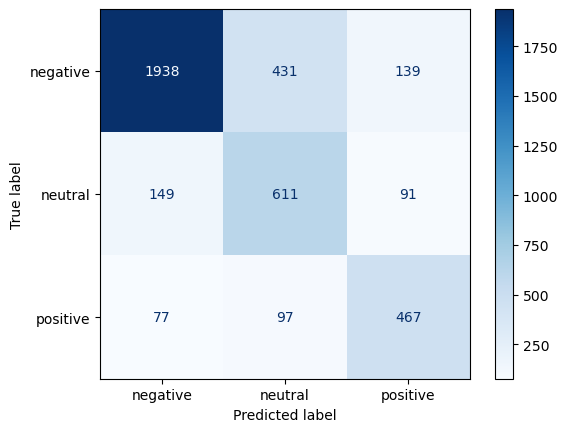

In [63]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = encoder.classes_)
disp.plot(cmap = 'Blues')

plt.savefig('../outputs/confusion_matrix.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In the above confusion matrix, the model misclassified neutral reviews as positive and negative, could be because of lack class specific words in those reviews. Also the model is particularly good at classifying negative reviews, suggested by f1 score in the classification report. We can also see that there is a good amount of negative reviews in the given data, which suggests, with more data of other classes the accuracy of the model can be improved.

In [66]:
with open('../models/sentiment_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('../models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('../models/label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)